# Care - 2D Example for time points between 390 and 399

Here, the volumetric images from camera CM02 have been flipped and translated. Next, the CM02 images have been registered pixel-wise. Finally, the second half of the images acquired from CM02 and the first half of images acquired from CM03 are denoised. We ignore the middle slices (30 to 40) and also the extreme slices (0 to 5, 65 to 70) during training.

In [1]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread, imwrite
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE
import glob
import copy

Using TensorFlow backend.


In [2]:
# A previously trained model is loaded by creating a new Care object without providing a 'config'.  
model = CARE(config=None, name='care_2D_kellerlab_with_normalization_with_pwregistration_float64', basedir='models')

Loading network weights from 'weights_best.h5'.


## Load images from CM02. Here we ignore the last 5 slices from CM02 because there is some registration artifact. Hint: Visualize!

In [3]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped_pwregistered/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print(imgs[0].shape)

10
(70, 896, 576)


 ## Take only the latter half of the z-slices from CM02

In [4]:
imgs_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][35:65, ...]
    imgs_CM02.append(temp)
print(imgs_CM02[5].shape)

(30, 896, 576)


## Load images from CM03

In [5]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print(imgs[0].shape)

10
(70, 896, 576)


## Take only the first half of the z-slices from CM03

In [6]:
imgs_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][0:35, ...]
    imgs_CM03.append(temp)
print(imgs_CM03[5].shape)

(35, 896, 576)


## Combine imgs_CM02 and imgs_CM03

In [7]:
input_train=copy.deepcopy(imgs_CM02)+copy.deepcopy(imgs_CM03)
print(len(input_train))

print(input_train[5].shape)
print(input_train[5].dtype)
print(input_train[15].shape)
print(input_train[15].dtype)

20
(30, 896, 576)
float64
(35, 896, 576)
float64


## At this point, we chop off the first and last 60 pixels from the X-dimension and Y-dimension and then normalize, in order to train subsequently

In [8]:
input_train_chopped=[]
for i in range(len(input_train)):
    input_train_chopped.append(input_train[i][:, 60:-60, 60:-60])
   

## Copy the mean and std from the training notebooks

In [9]:
# mean=np.mean(input_train_chopped)
# print(mean)
# std=np.std(input_train_chopped)
# print(std)
mean=np.array(118.11782916779707).astype('float64')
std=np.array(41.85176302980436).astype('float64')

In [10]:
input_train_chopped_normalized=copy.deepcopy(input_train_chopped)
for i in range(len(input_train_chopped_normalized)):
    input_train_chopped_normalized[i]=(input_train_chopped[i]-mean)/std


In [11]:
pred_train=copy.deepcopy(input_train_chopped_normalized)
for i in range(len(input_train_chopped_normalized)):
    for j in range(input_train_chopped_normalized[i].shape[0]):
        img=input_train_chopped_normalized[i][j, ..., np.newaxis]
        result_image=model.predict(img, axes='YXC', n_tiles=(4,4,1), normalizer= None)
        pred_train[i][j, ..., np.newaxis]=result_image
        

100%|██████████| 16/16 [00:00<00:00, 31.35it/s]  


100%|██████████| 16/16 [00:00<00:00, 33.83it/s]  


100%|██████████| 16/16 [00:00<00:00, 29.10it/s]  


100%|██████████| 16/16 [00:00<00:00, 32.87it/s]  


In [12]:
print(len(pred_train))
print(pred_train[0].shape)
print(pred_train[0].dtype)

20
(30, 776, 456)
float64


## Denormalize the predictions

In [13]:
pred_train_denormalized=copy.deepcopy(pred_train)
for i in range(len(pred_train)):
    pred_train_denormalized[i] = pred_train[i]*std + mean

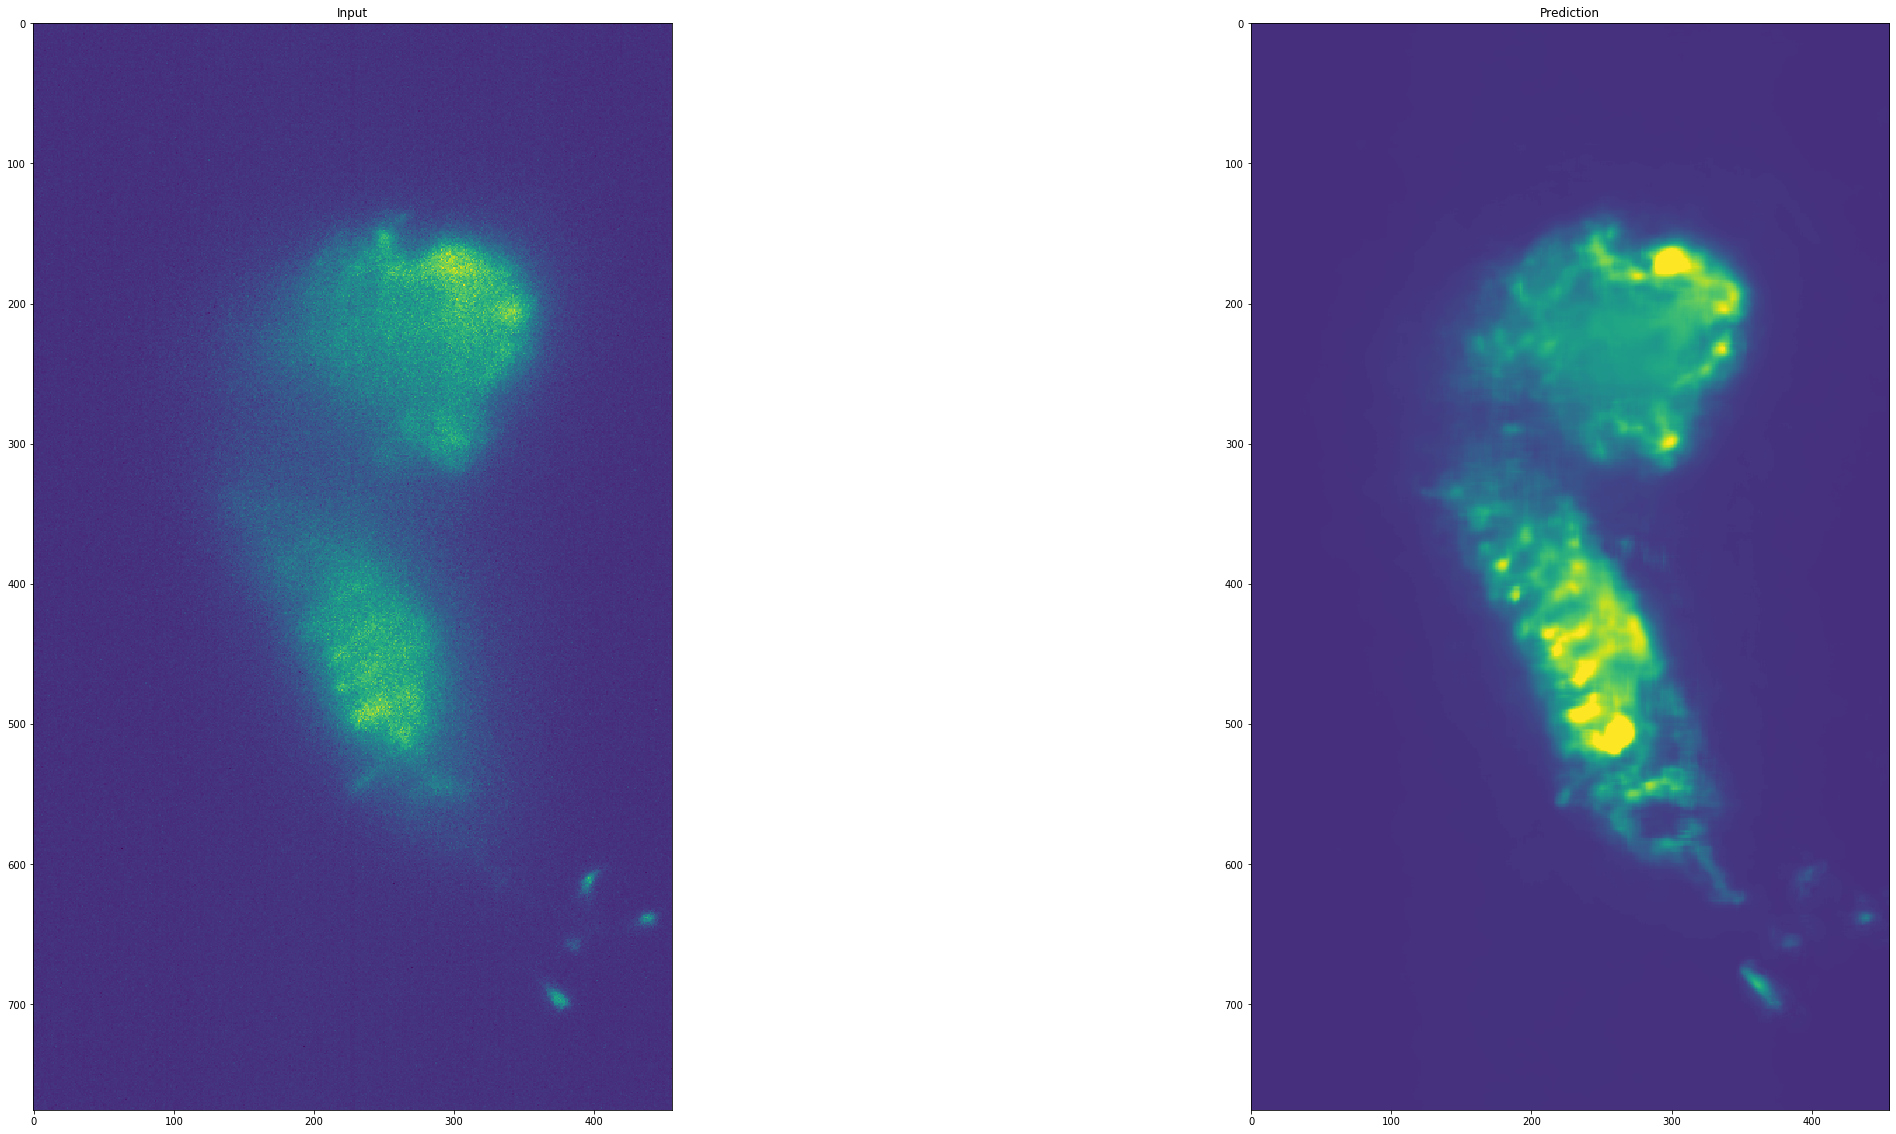

In [14]:
vmin=np.min(input_train_chopped[13][19, ...])
vmax=np.max(input_train_chopped[13][19, ...])

# Let's look at the results.
plt.figure(figsize=(40,20))
plt.subplot(1,2,1)
plt.imshow(input_train_chopped[13][19, ...], vmin=vmin, vmax=vmax)

plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_train_denormalized[13][19, ...], vmin=vmin, vmax=vmax)
plt.title('Prediction');

## A brief look at how the inetnsity values have changed after training !

In [16]:

print(np.min(pred_train_denormalized[10][20, ...]))
print(np.max(pred_train_denormalized[10][20, ...]))
print(np.min(input_train_chopped[10][20, ...]))
print(np.max(input_train_chopped[10][20, ...]))


93.92466595960289
813.3296807734645
73.0
384.0


## Reconstitute the images

In [19]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped_pwregistered/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]
for i in range(len(imgs)):
    imgs[i]=imgs[i][:-5, 60:-60, 60:-60]
## Take away the first and last 60 pixels in x and y dimension
## Also take away the last 5 slices in Z : only for CM02 
    
imgsnew=copy.deepcopy(imgs)

for i in range(10):
    imgsnew[i][0:35, ...]=copy.deepcopy(imgs[i][0:35,...])
    imgsnew[i][35:65, ...]=copy.deepcopy(pred_train_denormalized[i][...])
    fileindex=390+i
    print(str(fileindex))
    imwrite("/home/lalit/Desktop/03_Datasets/KellerLab/Data/Denoised/Care_with_proper_normalization_with_pwregistration/03August2019/CM02/"+str(fileindex)+".tif",np.array(imgsnew[i], dtype='float32'))
    imwrite("/home/lalit/Desktop/03_Datasets/KellerLab/Data/Denoised/Care_with_proper_normalization_with_pwregistration/03August2019/CM02_original_cropped/"+str(fileindex)+".tif",np.array(imgs[i], dtype='uint16'))
print(len(imgsnew))
print(imgsnew[0].shape)

390
391
392
393
394
395
396
397
398
399
10
(65, 776, 456)


In [20]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

for i in range(len(imgs)):
    imgs[i]=imgs[i][:, 60:-60, 60:-60]
    
imgsnew=copy.deepcopy(imgs)

for i in range(10):
    imgsnew[i][0:35, ...]=copy.deepcopy(pred_train_denormalized[i+10][...])
    imgsnew[i][35:70, ...]=copy.deepcopy(imgs[i][35:70, ...])
    fileindex=390+i
    print(str(fileindex))
    imwrite("/home/lalit/Desktop/03_Datasets/KellerLab/Data/Denoised/Care_with_proper_normalization_with_pwregistration/03August2019/CM03/"+str(fileindex)+".tif",np.array(imgsnew[i], dtype='float32'))
    imwrite("/home/lalit/Desktop/03_Datasets/KellerLab/Data/Denoised/Care_with_proper_normalization_with_pwregistration/03August2019/CM03_original_cropped/"+str(fileindex)+".tif",np.array(imgs[i], dtype='uint16'))
print(len(imgsnew))
print(imgsnew[0].shape)

390
391
392
393
394
395
396
397
398
399
10
(70, 776, 456)
